In [1]:
from imutils import paths
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import timeit

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses

import tensorflow_addons as tfa

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.xception import decode_predictions

C:\Users\cvpr\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
print("[INFO]: Trying to Read the images")
#  Configure the Image Location
# 이미지 위치 구성하기
imagePaths = list(paths.list_images(r'C:\Users\cvpr\Documents\Bishal\Allergic Rhinitis\Dataset\non_rotate'))

[INFO]: Trying to Read the images


In [3]:
imagePaths

['C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n13_1_00002_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n13_1_00003_left.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n13_2_00001_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n14_1_00001_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n14_1_00007_left.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n15_2_00005_left.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n1_1_00001_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n6_1_00004_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset

In [4]:
shuffle(imagePaths)
imagePaths

['C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n6_1_00006_left.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset2\\2\\26_1_00002_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset0\\0\\n13_2_00001_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset1\\0\\n18_2_00003_left.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset2\\2\\26_1_00001_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset1\\0\\n18_2_00002_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset1\\2\\18_3_00002_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset4\\0\\n35_2_00002_right.tif',
 'C:\\Users\\cvpr\\Documents\\Bishal\\Allergic Rhinitis\\Dataset\\non_rotate\\dataset4

In [5]:
imagePaths = list(paths.list_images("Dataset/non_rotate"))
len(imagePaths)
imagePaths[0].split(os.path.sep)[-3]

'dataset0'

In [6]:
trainCount = 0
testCount =0
for imagepath in imagePaths:
    if imagepath.split(os.path.sep)[-3] == "dataset4":
        testCount+=1
    else:
        trainCount+=1
totalCount = trainCount+testCount
print("trainCount-",trainCount)
print("testCount-", testCount)
print("totalCount", totalCount)

trainCount- 73
testCount- 17
totalCount 90


In [7]:
len(imagePaths)

90

In [103]:
from datetime import datetime
datetime.now().strftime('%H:%M:%S')

'14:17:53'

In [189]:
# Initialize data and labels
# 데이터 및 레이블 초기화/
data = []
labels = []
dirList= []

In [190]:
# Formatting data and labels
for imagePath in imagePaths:
    # Extract the class label from file name and append to labels
    # 파일 이름에서 클래스 레이블을 추출하고 레이블에 추가함
    label = imagePath.split(os.path.sep)[-2]
    #if label=="2":
     #   labels.append("1")
    #else:
     #   labels.append(label)
    labels.append(label)
    # Load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring the aspect ratio
    # 이미지를 로드하고, 컬러 채널을 스왑하고, 가로 세로 비율을 무시하고 고정 224x224 픽셀로 크기를 조정함
    image = cv2.imread(imagePath) 
    image = image.astype("float32") / 255.0
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    image = cv2.resize(image, (224,224))
    # Append to data
    # 데이터에 추가
    data.append(image)

# Convert the data and labels to NumPy arrays while scaling the pixel intensities to the range [0,1]
# 픽셀 강도를 [0,1] 범위로 조정하면서 데이터와 레이블을 NumPy 배열로 변환
data = np.array(data) / 255.0
labels = np.array(labels)

In [191]:
labels.shape

(90,)

In [192]:
labels

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '2',
       '2', '2', '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '2', '2', '2',
       '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '1', '1', '2', '2', '2', '2', '2', '2', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '1', '1', '2', '2', '2', '2', '2', '2'],
      dtype='<U1')

In [193]:
data[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


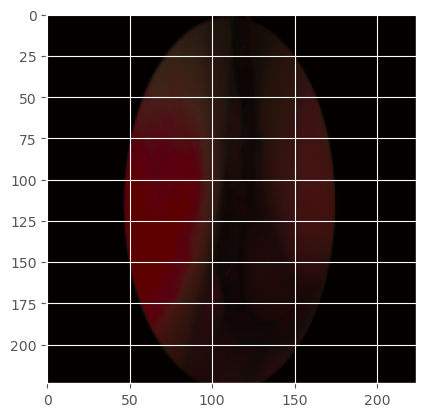

In [194]:
plt.imshow(data[1])
plt.savefig("[iter-4] [XCEPTN] plot-lab2-corres")

In [195]:
# Perform the one-hot encoding on the labels
# 레이블에 대해 원핫 인코딩 수행
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels, 3); 
print(labels)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [196]:
# Initialize the training data augmentation
# 교육 데이터 억멘테이션 초기화
trainAug = ImageDataGenerator(rotation_range=10, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
		shear_range=0.15,fill_mode="nearest", horizontal_flip=True)

In [197]:
labels.shape

(90, 3)

In [198]:
# Partition the data into training and testing splits using 80% of the training data and the remaining 20% for testing
# 교육 데이터의 80%, 테스트에 20%를 사용하여 데이터를 교육 및 테스트 분할로 분할
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [199]:
# Load the network, ensuring the Head-FC layer sets are left off
# Head-FC 레이어 세트가 포함되지 않도록 네트워크를 로드한다
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

In [200]:
# Construct the head model that will be placed on the top of the base model
# 보디 모델의 맨 위에 배치할 헤드 모델 구성
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4,4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [201]:
# Place the Head-FC model on top of the Base model - This become the actual model that we will train
# Head-FC 모델을 보디 모델 위에 배치한다. 이것이 우리가 교육할 실제 모델이 될 것이다.
model = Model(inputs=baseModel.input, outputs=headModel)

In [202]:
# Make sure that the basemodel layers will not be trained and only head model will be trained.
# 보디 모델 레이어가 훈련되지 않고 헤드 모델만 훈련되는지 확인한다.
for layer in baseModel.layers:
    layer.trainable = False

In [203]:
trainX.shape

(72, 224, 224, 3)

In [204]:
testX.shape

(18, 224, 224, 3)

In [205]:
# Set the hyper-parameters
# 하이퍼 파라미터 설정
# INIT_LR = 1e-3
INIT_LR = 0.001
EPOCHS = 100
BS = 8

In [206]:
# Compile the Model
# 모델 컴파일
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, metrics=["accuracy"])

In [207]:
# Train the Network Model
# 모델 교육
print("[INFO] Model Training")
start = timeit.default_timer()
H = model.fit(
        trainAug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS)

[INFO] Model Training
Epoch 1/100
9/9 [==============================] - 5s 186ms/step - loss: 1.2941 - accuracy: 0.2778 - val_loss: 0.9980 - val_accuracy: 0.5000
Epoch 2/100
9/9 [==============================] - 1s 97ms/step - loss: 1.0607 - accuracy: 0.4722 - val_loss: 1.0125 - val_accuracy: 0.6667
Epoch 3/100
9/9 [==============================] - 1s 98ms/step - loss: 1.2100 - accuracy: 0.4444 - val_loss: 0.9164 - val_accuracy: 0.5556
Epoch 4/100
9/9 [==============================] - 1s 93ms/step - loss: 1.0414 - accuracy: 0.4861 - val_loss: 0.9125 - val_accuracy: 0.6111
Epoch 5/100
9/9 [==============================] - 1s 92ms/step - loss: 0.9542 - accuracy: 0.6111 - val_loss: 0.9127 - val_accuracy: 0.6111
Epoch 6/100
9/9 [==============================] - 1s 95ms/step - loss: 0.8368 - accuracy: 0.6667 - val_loss: 0.9322 - val_accuracy: 0.6111
Epoch 7/100
9/9 [==============================] - 1s 94ms/step - loss: 0.9048 - accuracy: 0.6250 - val_loss: 0.9560 - val_accuracy: 0.61

Epoch 59/100
9/9 [==============================] - 1s 96ms/step - loss: 0.6409 - accuracy: 0.7778 - val_loss: 1.1040 - val_accuracy: 0.6111
Epoch 60/100
9/9 [==============================] - 1s 98ms/step - loss: 0.5778 - accuracy: 0.7500 - val_loss: 1.1908 - val_accuracy: 0.5556
Epoch 61/100
9/9 [==============================] - 1s 93ms/step - loss: 0.6076 - accuracy: 0.6944 - val_loss: 1.1198 - val_accuracy: 0.5556
Epoch 62/100
9/9 [==============================] - 1s 95ms/step - loss: 0.5498 - accuracy: 0.8056 - val_loss: 1.1924 - val_accuracy: 0.6111
Epoch 63/100
9/9 [==============================] - 1s 102ms/step - loss: 0.6485 - accuracy: 0.7083 - val_loss: 1.1844 - val_accuracy: 0.5556
Epoch 64/100
9/9 [==============================] - 1s 93ms/step - loss: 0.6134 - accuracy: 0.7500 - val_loss: 1.1251 - val_accuracy: 0.4444
Epoch 65/100
9/9 [==============================] - 1s 100ms/step - loss: 0.5966 - accuracy: 0.7500 - val_loss: 1.1378 - val_accuracy: 0.5000
Epoch 66/10

In [208]:
stop = timeit.default_timer()
print('Total Training Time: ', stop - start) 

Total Training Time:  95.59319390000019


In [209]:
testX.shape

(18, 224, 224, 3)

In [210]:
testX[:1].shape

(1, 224, 224, 3)

In [211]:
# Make predictions on the testing set
# 테스트 세트에서 예측한다
print("Making Predictions on the Test Set")
predIdxs = model.predict(testX, batch_size=BS)
preds = predIdxs
predIdxs = np.argmax(predIdxs, axis=1)
print("Classification Report")
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

Making Predictions on the Test Set
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.00      0.00      0.00         3
           2       0.50      0.50      0.50         6

    accuracy                           0.50        18
   macro avg       0.35      0.39      0.37        18
weighted avg       0.44      0.50      0.47        18



In [212]:
preds

array([[0.14503962, 0.09891181, 0.75604856],
       [0.79591995, 0.0665224 , 0.13755763],
       [0.03089721, 0.10378978, 0.865313  ],
       [0.6718289 , 0.05766973, 0.27050132],
       [0.551307  , 0.13920732, 0.3094857 ],
       [0.48703772, 0.37140688, 0.14155532],
       [0.26943946, 0.4031893 , 0.3273713 ],
       [0.95333487, 0.00657543, 0.04008965],
       [0.4588591 , 0.00142383, 0.5397171 ],
       [0.9908167 , 0.00111817, 0.00806514],
       [0.96253675, 0.03000593, 0.00745734],
       [0.7372437 , 0.01681095, 0.2459453 ],
       [0.87648195, 0.01551885, 0.10799929],
       [0.9401345 , 0.0031972 , 0.05666824],
       [0.00210387, 0.01540488, 0.9824913 ],
       [0.76074487, 0.06286356, 0.1763916 ],
       [0.27086556, 0.13877976, 0.5903547 ],
       [0.00879322, 0.42800313, 0.56320363]], dtype=float32)

In [213]:
len(predIdxs)

18

In [214]:
# Compute Confusion Matrix and derrive raw, accuracy, sensitivity, specificity from it
# 혼란 매트릭스
cm= confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1] +cm[2,2]) / total

sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
# 혼란 매트릭스 보기
print("Confusion Matrix and its Derrivatives")
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Confusion Matrix and its Derrivatives
[[6 0 3]
 [3 0 0]
 [2 1 3]]
acc: 0.5000
sensitivity: 1.0000
specificity: 0.0000


In [215]:
acc = (cm[0,0] + cm[1,1] + cm[2,2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0,2])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1] + cm[1,2])
specificity2 = cm[2, 2] / (cm[2, 0] + cm[2, 1] + cm[2,2])
specificity = (specificity + specificity2) / 2
print(acc)
print(sensitivity)
print(specificity)

0.5
0.6666666666666666
0.25


In [216]:
H.history["accuracy"]

[0.2777777910232544,
 0.4722222089767456,
 0.4444444477558136,
 0.4861111044883728,
 0.6111111044883728,
 0.6666666865348816,
 0.625,
 0.6111111044883728,
 0.6111111044883728,
 0.5972222089767456,
 0.6111111044883728,
 0.6944444179534912,
 0.6527777910232544,
 0.5972222089767456,
 0.6111111044883728,
 0.6805555820465088,
 0.6388888955116272,
 0.7083333134651184,
 0.6111111044883728,
 0.6111111044883728,
 0.6805555820465088,
 0.6944444179534912,
 0.6805555820465088,
 0.625,
 0.6666666865348816,
 0.7083333134651184,
 0.75,
 0.6527777910232544,
 0.6944444179534912,
 0.7083333134651184,
 0.7222222089767456,
 0.625,
 0.6666666865348816,
 0.6388888955116272,
 0.6666666865348816,
 0.7083333134651184,
 0.7777777910232544,
 0.7777777910232544,
 0.7777777910232544,
 0.7638888955116272,
 0.7638888955116272,
 0.6666666865348816,
 0.6944444179534912,
 0.6944444179534912,
 0.7916666865348816,
 0.75,
 0.7083333134651184,
 0.6666666865348816,
 0.75,
 0.7916666865348816,
 0.7916666865348816,
 0.75,
 0.

Final Plot Generated.


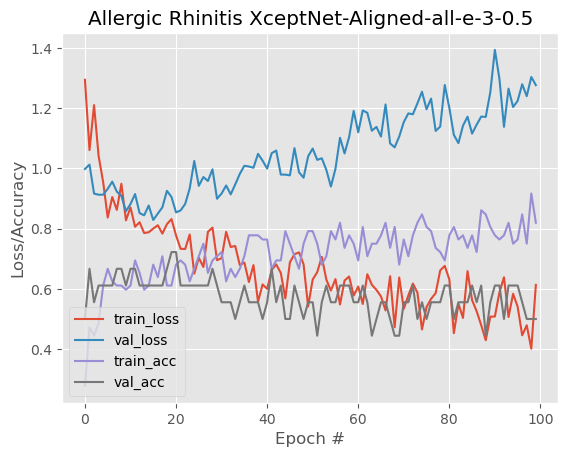

In [217]:
# plot the training loss and accuracy
# 플롯 그래프
print("Final Plot Generated.")
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Allergic Rhinitis XceptNet-Aligned-all-e-3-0.5")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("[iter-4] [XCEPTN] plot-lab2")

model.output_shape # model summary representation
model.summary() # model configuration
model.get_config() # list all weight tensors in the model

In [ ]:
model.output_shape

In [ ]:
model.summary()

model.summary()

In [ ]:
model.summary()

In [ ]:
preds

In [ ]:
model.save("ARhinitisModel", save_format="h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

print("[INFO] saving Allergic Rhinitis detector model...")
model.save("ARhinitisModel", save_format="h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

decoded = imagenet_utils.decode_predictions(preds)

gradCAM


In [36]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras

In [37]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [38]:
testX[0].shape

(224, 224, 3)

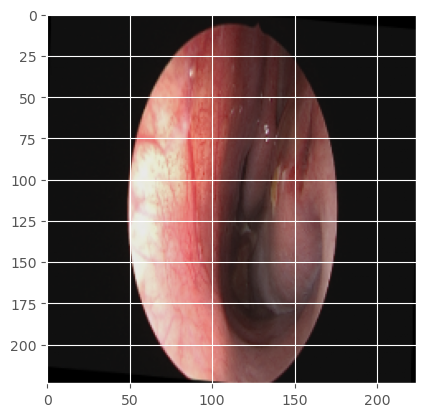

In [39]:
plt.imshow(testX[0])
plt.show()

preprocess_input = keras.applications.xception.preprocess_input

for i in testX:
    image = np.expand_dims(i, axis=0)
    image = imagenet_utils.preprocess_input(i)

In [42]:
testImage = testX[12]
testImage = np.expand_dims(testImage, axis = 0)

In [43]:
testImage = np.uint8(255 * testImage)


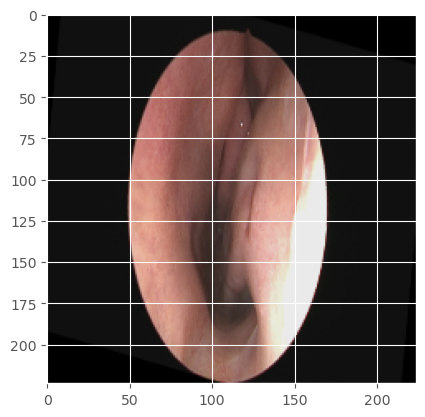

In [44]:
plt.imshow(testImage[0])
plt.show()

To save img

In [45]:
img101 = keras.preprocessing.image.array_to_img(testImage[0])

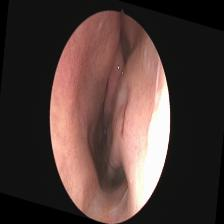

In [46]:
img101.save("temp.jpg")
display(Image("temp.jpg"))

Select Last Layer

In [47]:
last_conv_layer_name = "block14_sepconv2_act"

Get Heatmap

[[7.5773758e-01 4.0521350e-02 2.0174100e-01]
 [9.0666309e-02 3.3217065e-02 8.7611663e-01]
 [7.6192573e-02 1.4452259e-01 7.7928478e-01]
 [3.3923325e-01 6.5505415e-02 5.9526134e-01]
 [9.5285147e-02 8.5699815e-01 4.7716666e-02]
 [9.9570090e-01 1.5510028e-03 2.7480661e-03]
 [6.4452279e-01 1.1024495e-01 2.4523222e-01]
 [8.5153824e-01 1.2440102e-01 2.4060681e-02]
 [9.9375063e-01 3.5841626e-04 5.8908891e-03]
 [9.9985802e-01 7.0320511e-06 1.3496158e-04]
 [7.5881130e-01 2.3926780e-01 1.9209004e-03]
 [9.9635714e-01 8.9222245e-04 2.7506510e-03]
 [9.9995399e-01 8.2268352e-06 3.7751954e-05]
 [6.3500404e-01 5.2946275e-03 3.5970131e-01]
 [1.3827731e-02 6.2396157e-01 3.6221063e-01]
 [9.0006900e-01 1.1264326e-02 8.8666715e-02]
 [4.3508253e-01 2.1344087e-01 3.5147658e-01]
 [9.7628844e-01 1.7384226e-03 2.1973185e-02]]
(7, 7)


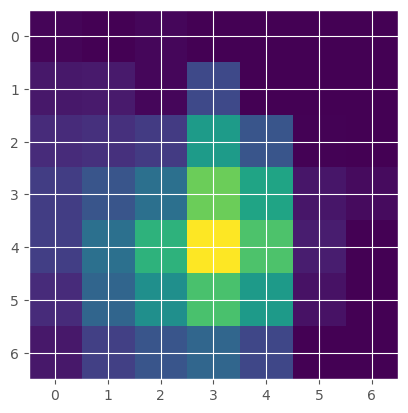

In [48]:
# Prepare image
#img_array = testX[:1]

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
#preds = model.predict(testImage)
#print("Predicted:", decode_predictions(preds, top=1)[0])
print(preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(testImage, model, last_conv_layer_name)
print(heatmap.shape)

# Display heatmap
plt.imshow(heatmap)
plt.show()

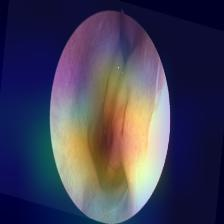

In [49]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, img_=None):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)
    img = img_
   

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam("temp.jpg", heatmap, img_=testImage[0])

In [57]:
testX[0].shape

(224, 224, 3)

In [50]:
import gradCam2

In [51]:
img_ = imagePaths[24]

In [52]:
heat = gradCam2.getHeatMap(img_, model, "block14_sepconv2_act",imageType="path")

In [53]:
gradCam2.saveGradCam(img_, heat)